# Setting up an Experiment Baseline Framework

This serves as a baseline framework for the multilabel neural nilm experiments.

## Import Python Modules

In [1]:
from __future__ import print_function, division
import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')


from data import Environment, get_status
from data.generator import Seq2Seq, Seq2Point 

from models import FCN, ResNet, ConvGRU, ConvLSTM, FCN_AE

from experiments import Experiment
from experiments.metrics import validation_report, evaluation_report, confusion_matrix_report, roc_report

from utils.path_finder import NILMTK_RAW, SCENARIOS, SOURCES, PRETRAINED

In [2]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Setup Experiment Framework

In [3]:
SCENARIO = 0
BATCH_SIZE = 32
WINDOW_SIZE = 100
EPOCHS = 1

In [4]:
experiment = Experiment(scenario=SCENARIO)

In [5]:
experiment.setup_environments() 

Preparing REDD building 1 ...
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loadin

In [6]:
experiment.setup_running_params(model=ConvLSTM(1,3), epochs=EPOCHS, window=WINDOW_SIZE, batch_size=BATCH_SIZE)

## Load Data 

In [7]:
%%time

train, validation, test = experiment.load_environments()

CPU times: user 20.5 ms, sys: 14.8 ms, total: 35.3 ms
Wall time: 21.4 ms


In [8]:
if experiment.model.is_autoencoder():
    ds_train = Seq2Seq(data=train, length=WINDOW_SIZE, train=True)
    ds_validation = Seq2Seq(data=validation, length=WINDOW_SIZE, train=False)
    ds_test = Seq2Seq(data=test, length=WINDOW_SIZE, train=False)
else: 
    ds_train = Seq2Point(data=train, length=WINDOW_SIZE, train=True)
    ds_validation = Seq2Point(data=validation, length=WINDOW_SIZE, train=False)
    ds_test = Seq2Point(data=test, length=WINDOW_SIZE, train=False)

In [9]:
train_generator = ds_train.load(batch_size = BATCH_SIZE, shuffle=True)
valid_generator = ds_validation.load(batch_size = BATCH_SIZE, shuffle=False)
test_generator = ds_test.load(batch_size = BATCH_SIZE, shuffle=False)

In [10]:
len(ds_train)

235495

## Train Neural Network 

In [11]:
%%time

filename = os.path.join(PRETRAINED, "{}/scenario-{}.pth".format(experiment.model.name, experiment.scenario))
train_loss, valid_loss, test_loss = experiment.train(train_generator, valid_generator, test_generator, filename)

[1/1] train_loss: 0.48686 valid_loss: 0.44578 test_loss: 0.44578 
Validation loss decreased (inf --> 0.445783).  Saving model ...
CPU times: user 7min 9s, sys: 11.2 s, total: 7min 21s
Wall time: 3min 35s


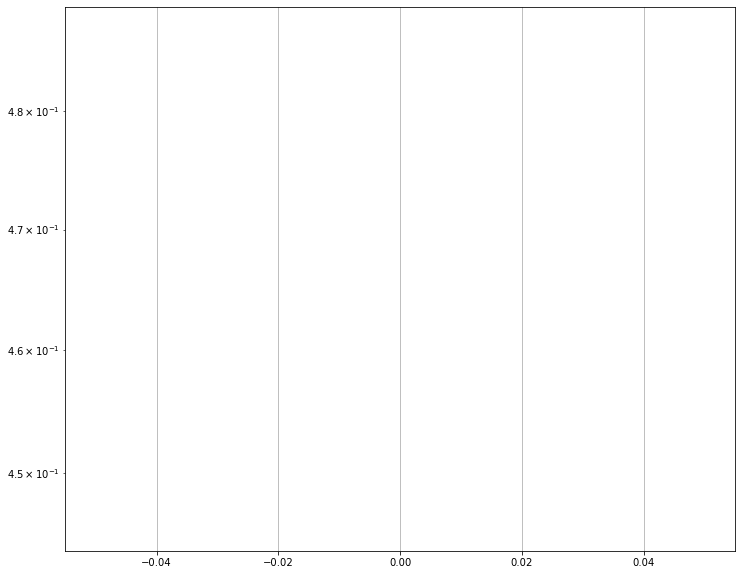

In [12]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.plot(test_loss)

plt.yscale('log')
plt.grid(True)

## Predict Output

In [13]:
%%time

predictions = pd.DataFrame(columns=experiment.appliances)
y_test = pd.DataFrame(columns=experiment.appliances)


for i, (appliance, thresholds) in enumerate(experiment.appliances.items()):

    y_true, y_predicted = experiment.test(test_generator, i)

    y_test[appliance] = y_true
    predictions[appliance] = get_status(y_predicted, 0.5, thresholds[0], thresholds[1])


CPU times: user 2min 30s, sys: 2.07 s, total: 2min 32s
Wall time: 1min 22s


In [14]:
target_results = evaluation_report(y_test.values, predictions.values, targets=experiment.appliances, mode="target")
target_results

,Accuracy,Precision,Recall,F1 Score,MCC
fridge,0.734239,0.0,0.0,0.0,0.0
dish washer,0.906741,0.0,0.0,0.0,0.0
washer dryer,0.962805,0.0,0.0,0.0,0.0


In [15]:
model_results = evaluation_report(y_test.values, predictions.values, mode="averaged")
model_results

,Precision,Recall,F1 Score
macro,0.0,0.0,0.0
micro,0.0,0.0,0.0


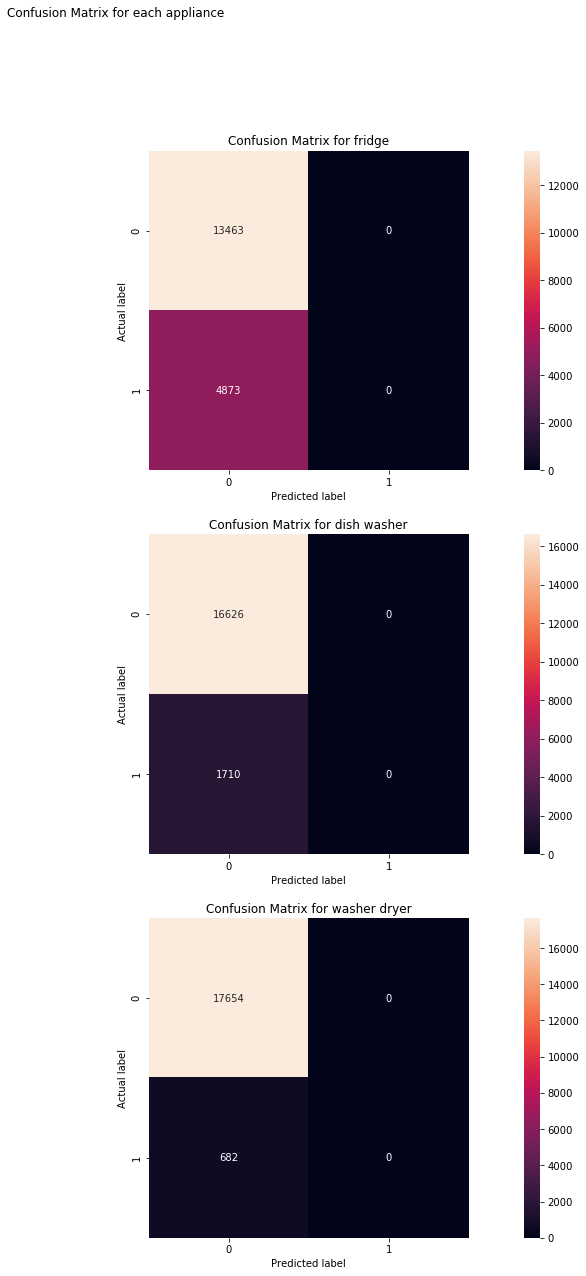

In [16]:
confusion = confusion_matrix_report(y_test.values, predictions.values, experiment.appliances)
confusion